In [2]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Model selection
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV,
    learning_curve,
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score,
)

# Pipelines & preprocessing
from sklearn.pipeline import Pipeline    # koristite kad NEMA SMOTE/samplera
from imblearn.pipeline import Pipeline as ImbPipeline   # koristite kad ima SMOTE/samplera
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

# Feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Imbalanced-learn samplers
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

# Distributions for hyperparameter search
from scipy.stats import randint, loguniform

# Global seed
SEED = 56
np.random.seed(SEED)


In [3]:
df = pd.read_csv(r"C:\Users\korisnk\Desktop\home-credit-default-risk\application_train.csv")
cost_default_FP = 10000
cost_default_FN = 100000
print("data frame dimenzije: ", df.shape)
print("prikaz kolona: \n", df.columns)

data frame dimenzije:  (307511, 122)
prikaz kolona: 
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


prikaz balansiranosti klasa:


<Axes: xlabel='TARGET'>

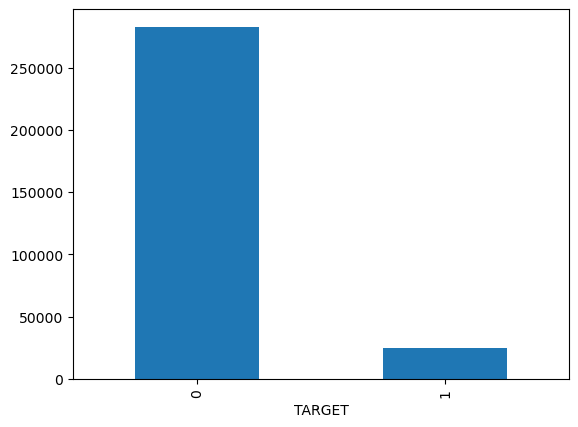

In [4]:
print("prikaz balansiranosti klasa:")
df['TARGET'].value_counts().plot(kind='bar')

In [5]:
# Ključni atributi koje čuvamo čak i ako imaju puno NaN
kolone_koje_zadrzavamo = ['EXT_SOURCE_1', 'OCCUPATION_TYPE', 'OWN_CAR_AGE']

# Provera broja redova
total_rows = df.shape[0]

# Izračunavanje procenta NaN po koloni
missing_fraction = df.isnull().sum() / total_rows

# Kolone sa preko 30% NaN koje nisu u listi za zadržavanje
cols_over_30_percent_missing = missing_fraction[
    (missing_fraction > 0.3) & (~missing_fraction.index.isin(kolone_koje_zadrzavamo))
]

print(f"❌ Broj kolona koje će biti uklonjene (preko 30% NaN, nebitne): {len(cols_over_30_percent_missing)}")
print("Te kolone su:\n", cols_over_30_percent_missing.sort_values(ascending=False))

# Brisanje kolona koje ne želimo i imaju previše NaN
df = df.drop(columns=cols_over_30_percent_missing.index)

# Brisanje redova sa više od 20% NaN
df = df[df.isnull().mean(axis=1) <= 0.2]

print(f"✅ Preostalo redova: {df.shape[0]}, kolona: {df.shape[1]}")

❌ Broj kolona koje će biti uklonjene (preko 30% NaN, nebitne): 47
Te kolone su:
 COMMONAREA_AVG                  0.698723
COMMONAREA_MEDI                 0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MEDI           0.683550
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
FLOORSMIN_MODE                  0.678486
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
YEARS_BUILD_MEDI                0.664978
LANDAREA_AVG                    0.593767
LANDAREA_MODE                   0.593767
LANDAREA_MEDI                   0.593767
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_MODE               0.585160
NONLIVINGAREA_AVG

In [6]:
# Ručno definisane kolone koje želiš da izbaciš (npr. ID, flagovi, redundanse)
cols_to_drop = [
    'SK_ID_CURR', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS',
    'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'FLAG_PHONE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_EMAIL'
]

# Ukloni ih samo ako postoje u df
cols_to_drop_filtered = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop_filtered)

print(f"🧹 Konačan broj kolona posle ručnog čišćenja: {df.shape[1]}")

🧹 Konačan broj kolona posle ručnog čišćenja: 28


In [7]:
# Korelaciona matrica za numeričke kolone
corr_matrix = df.corr(numeric_only=True)

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Izdvoj parove sa korelacijom većom od 0.85
high_corr_pairs = upper_triangle.stack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.85]

print("🔗 Atributi sa međusobnom korelacijom većom od 0.85:")
display(high_corr_pairs)

🔗 Atributi sa međusobnom korelacijom većom od 0.85:


AMT_CREDIT            AMT_GOODS_PRICE                0.986968
REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY    0.950842
CNT_CHILDREN          CNT_FAM_MEMBERS                0.879161
dtype: float64

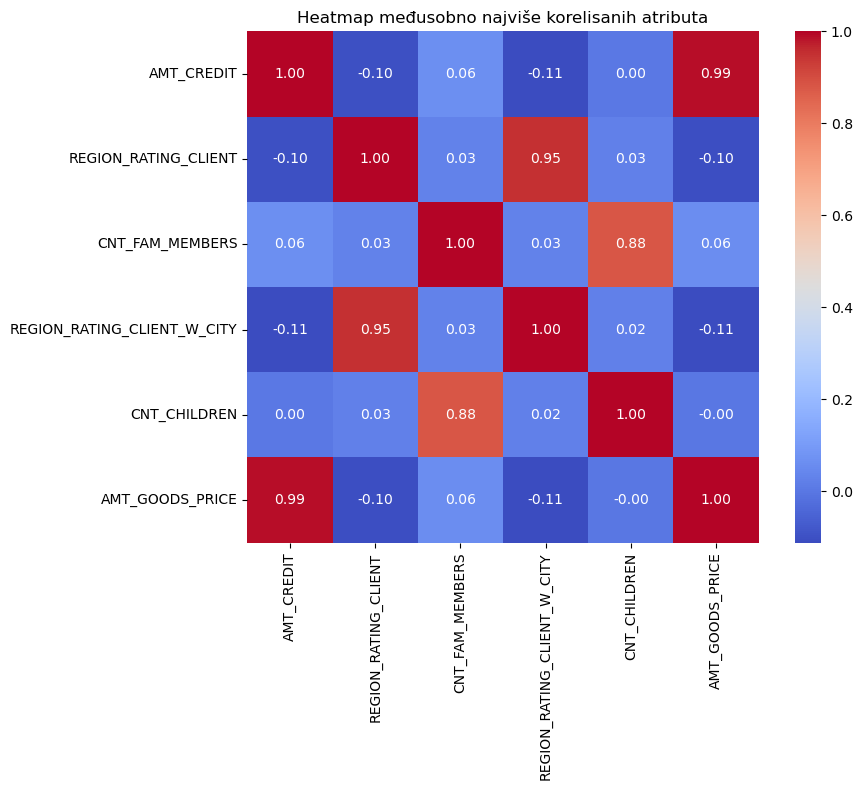

In [8]:
# Uzmimo sve kolone koje se pojavljuju u tim parovima
top_corr_columns = list(set(high_corr_pairs.index.get_level_values(0)).union(
                         set(high_corr_pairs.index.get_level_values(1))))

# Prikaz heatmap za te kolone
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Heatmap međusobno najviše korelisanih atributa")
plt.tight_layout()
plt.show()

In [9]:
kolone_za_uklanjanje = [
    'AMT_GOODS_PRICE',
    'REGION_RATING_CLIENT_W_CITY',
    'CNT_FAM_MEMBERS'
]

df = df.drop(columns=[col for col in kolone_za_uklanjanje if col in df.columns])
print("📉 Uklonjene kolone zbog visoke međusobne korelacije:", kolone_za_uklanjanje)
print("📐 Nove dimenzije skupa:", df.shape)
importances = df

📉 Uklonjene kolone zbog visoke međusobne korelacije: ['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'CNT_FAM_MEMBERS']
📐 Nove dimenzije skupa: (307511, 25)


In [10]:
# 🔹 Podela na X i y
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

# encoding premesten u pipeline (GDE MU JE I MESTO)

In [11]:
#impute raditi u pipeline tako da se ovaj proces prilagodi pojedinacnom modelu

def create_preprocessor(X):

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])
    
    return preprocessor




In [12]:
# TUNING LOGISCTIC REGRESSION PARAMETARA OVDE

# uzorak od 30,000 redova za tuning parametara
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=30000, stratify=y, random_state=56
)

preprocessor = create_preprocessor(X_sample)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Definiši prostor hiperparametara za pretragu
param_dist = {
    'clf__C': loguniform(1e-4, 1e4),
    'clf__penalty': ['l1', 'l2']
}

# Kreiraj RandomizedSearchCV objekat
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,              # broj proba
    cv=4,                   # broj foldova za cross-validaciju
    scoring='recall',       # metrika za optimizaciju
    random_state=56,
    n_jobs=6, # 6 CPU threadova sasvim dovoljno
    verbose=1
)

# Pokreni pretragu (pretpostavi da imaš X_train i y_train)
random_search.fit(X_sample, y_sample)

# Sačuvaj najbolje parametre u promenljivu
best_params_lr = random_search.best_params_
# izbacuje clf__ prefikse
best_params_lr = {k.split('__')[1]: v for k, v in best_params_lr.items() if k.startswith('clf__')}

print("Najbolji parametri:", best_params_lr)
print("Najbolji skor:", random_search.best_score_)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Najbolji parametri: {'C': np.float64(7473.685258720684), 'penalty': 'l2'}
Najbolji skor: 0.015272209039085728


In [13]:
# TUNING RANDOM FOREST PARAMETARA OVDE


# Uzorak od 30.000 redova za tuning
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=30000, stratify=y, random_state=56
)

# Pretpostavljamo da već imaš create_preprocessor funkciju
preprocessor = create_preprocessor(X_sample)

# Kreiraj pipeline sa preprocesorom i Random Forest modelom
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', RandomForestClassifier(random_state=56, n_jobs=-1))
])

# Definiši prostor hiperparametara za pretragu
param_dist = {
    'clf__n_estimators': randint(50, 300),        # broj stabala
    'clf__max_depth': randint(3, 10),             # maksimalna dubina
    'clf__min_samples_split': randint(10, 30),    # minimalni broj uzoraka za podelu
    'clf__min_samples_leaf': randint(25, 50),     # minimalni broj uzoraka u listu
    'clf__bootstrap': [True, False]               # da li koristi bootstrap uzorkovanje
}

# Kreiraj RandomizedSearchCV objekat
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='recall',
    random_state=56,
    n_jobs=6,
    verbose=1
)

# Pokreni pretragu
random_search.fit(X_sample, y_sample)

# Sačuvaj najbolje parametre
best_params_rf = random_search.best_params_
best_params_rf = {k.split('__')[1]: v for k, v in best_params_rf.items() if k.startswith('clf__')}

print("Najbolji parametri:", best_params_rf)
print("Najbolji skor:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Najbolji parametri: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 40, 'min_samples_split': 10, 'n_estimators': 212}
Najbolji skor: 0.0


In [14]:
# TUNING XGBOOST PARAMETARA OVDE

# Uzorak od 30.000 redova za tuning
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=30000, stratify=y, random_state=56
)

# Pretpostavljamo da već imaš create_preprocessor funkciju
preprocessor = create_preprocessor(X_sample)

# Kreiraj pipeline sa preprocesorom i XGBoost modelom
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=56
    ))
])

# Definiši prostor hiperparametara za pretragu
param_dist = {
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': loguniform(0.01, 0.3),
    'clf__subsample': loguniform(0.5, 1.0),
    'clf__colsample_bytree': loguniform(0.5, 1.0),
    'clf__gamma': loguniform(1e-8, 1.0),
    'clf__reg_lambda': loguniform(1e-4, 10.0),
    'clf__reg_alpha': loguniform(1e-4, 10.0)
}

# Kreiraj RandomizedSearchCV objekat
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='recall',  # možeš zameniti ako ti treba npr. f1_macro
    random_state=56,
    n_jobs=6,
    verbose=1
)

# Pokreni pretragu
random_search.fit(X_sample, y_sample)

# Sačuvaj najbolje parametre (izbaci clf__ prefikse)
best_params_xgb = {
    k.split('__')[1]: v for k, v in random_search.best_params_.items()
    if k.startswith('clf__')
}

print("Najbolji parametri:", best_params_xgb)
print("Najbolji skor:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Najbolji parametri: {'colsample_bytree': np.float64(0.6539511819234505), 'gamma': np.float64(0.0005654295361034988), 'learning_rate': np.float64(0.19901576995505627), 'max_depth': 8, 'n_estimators': 117, 'reg_alpha': np.float64(0.13475398771660926), 'reg_lambda': np.float64(0.08117115777061318), 'subsample': np.float64(0.6264457401634691)}
Najbolji skor: 0.04995399165033654


In [15]:

# 1) Preprocessor (već ga imaš)
preprocessor = create_preprocessor(X)

# 2) MODELI BEZ BALANSIRANJA
models_imbalance = {
    "Logistic Regression": LogisticRegression(
        **best_params_lr, solver='liblinear', max_iter=1000  # bez class_weight
    ),
    "Random Forest": RandomForestClassifier(
        **best_params_rf, n_jobs=-1  # bez class_weight
    ),
    "XGBoost": XGBClassifier(
        **best_params_xgb, eval_metric='logloss', n_jobs=-1  # bez scale_pos_weight
    )
}

# 3) Metričke funkcije
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}
cv = StratifiedKFold(n_splits=5, shuffle=True)

# 4) CV evaluacija po modelu (bez data leak-a)
for name, model in models_imbalance.items():
    print(f"\n📊 IMBALANCE — CV rezultati za: {name}")

    selector = SelectFromModel(model, threshold="median")  # možeš i None (mean), ali median je stabilniji

    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', model)
    ])

    cv_results = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        error_score='raise'
    )
    for metric in scoring:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")



📊 IMBALANCE — CV rezultati za: Logistic Regression
accuracy: 0.9193
roc_auc: 0.7304
f1: 0.0144
recall: 0.0073
precision: 0.4959

📊 IMBALANCE — CV rezultati za: Random Forest
accuracy: 0.9193
roc_auc: 0.7308
f1: 0.0000
recall: 0.0000
precision: 0.0000

📊 IMBALANCE — CV rezultati za: XGBoost
accuracy: 0.9180
roc_auc: 0.7336
f1: 0.0567
recall: 0.0305
precision: 0.3973



📊 Konfuziona matrica i trošak za: Logistic Regression


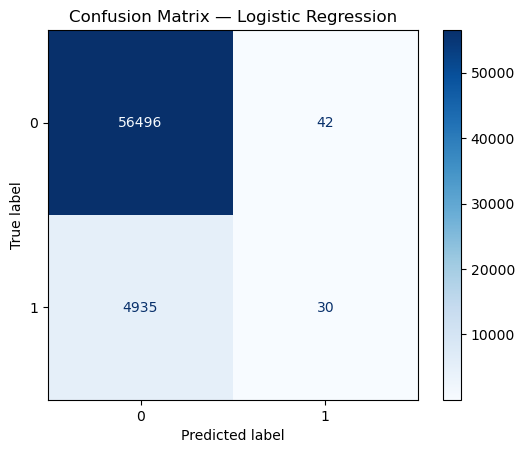

False Positives: 42, False Negatives: 4935
💸 Ukupan trošak: 493,920,000

📊 Konfuziona matrica i trošak za: Random Forest


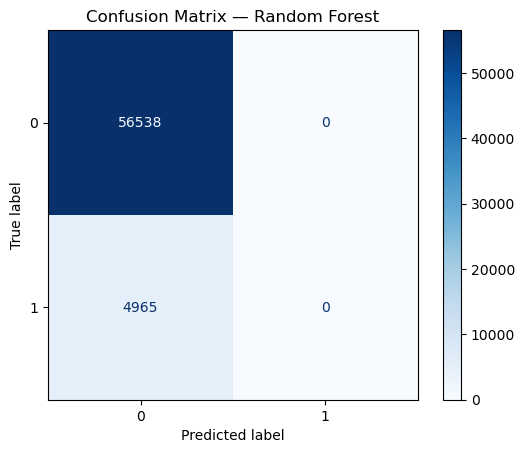

False Positives: 0, False Negatives: 4965
💸 Ukupan trošak: 496,500,000

📊 Konfuziona matrica i trošak za: XGBoost


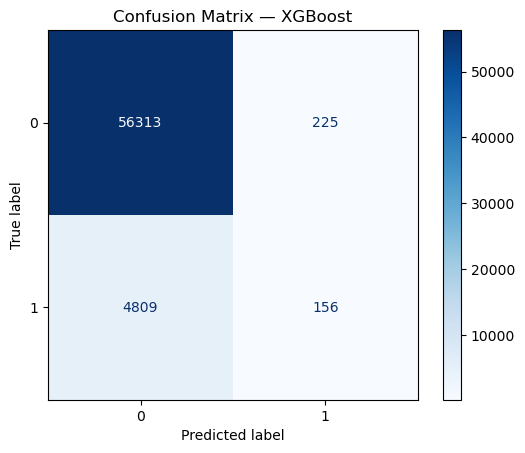

False Positives: 225, False Negatives: 4809
💸 Ukupan trošak: 483,150,000


In [16]:

# Troškovi
cost_default_FP = 10000
cost_default_FN = 100000

# ✅ Jedinstven, stabilan split (isti kao dole)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=56
)

for name, model in models_imbalance.items():
    print(f"\n📊 Konfuziona matrica i trošak za: {name}")

    selector = SelectFromModel(model, threshold="median")

    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', model)
    ])

    # Treniraj model
    pipe.fit(X_train, y_train)

    # Predikcije (default threshold=0.5)
    y_pred = pipe.predict(X_test)

    # ✅ Fiksiraj redosled klasa da TN,FP,FN,TP budu tačni i konzistentni
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    # Izvuci TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()

    # Trošak
    total_cost = fp * cost_default_FP + fn * cost_default_FN
    print(f"False Positives: {fp}, False Negatives: {fn}")
    print(f"💸 Ukupan trošak: {total_cost:,}")


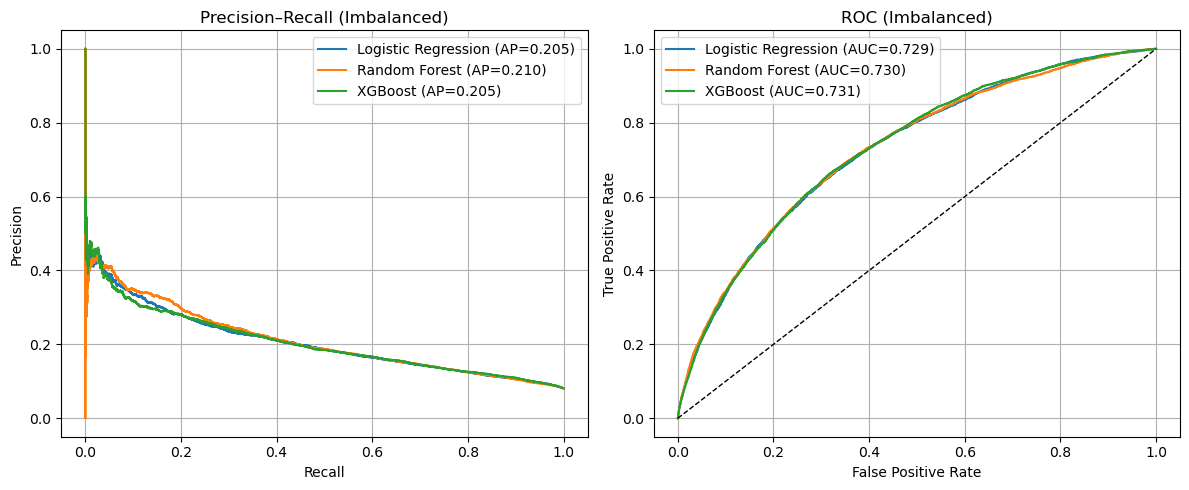

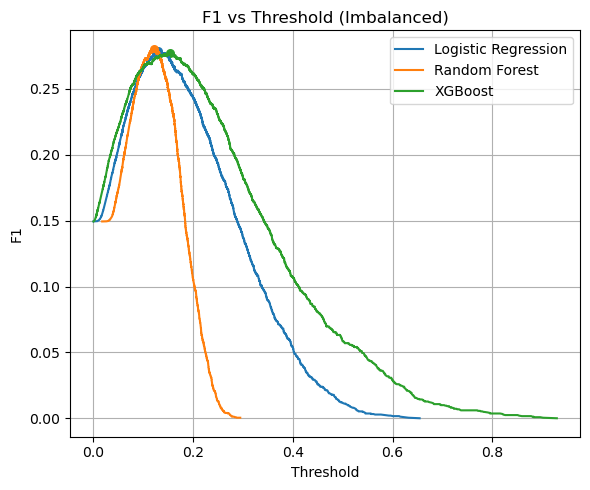

In [17]:
# ROC–AUC, Precision–Recall i F1-krive za models_imbalance (isti split/preprocessor)


# Skupljamo krive po modelu
roc_curves = {}
pr_curves  = {}
f1_curves  = {}

for name, model in models_imbalance.items():
    selector = SelectFromModel(clone(model), threshold="median")

    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', clone(model))
    ])

    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc)

    # Precision–Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    pr_curves[name] = (precision, recall, ap, pr_thresholds)

    # F1 vs threshold (poravnaj sa pr_thresholds)
    # precision/recall imaju dužinu len(thresholds)+1 → preskačemo prvi element
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_all = 2 * precision * recall / (precision + recall)
    f1_at_t = f1_all[1:]                 # poravnanje sa pr_thresholds
    f1_curves[name] = (pr_thresholds, f1_at_t)

# PR i ROC na jednoj figuri (2 subplota)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Precision–Recall
ax = axes[0]
for name, (precision, recall, ap, _) in pr_curves.items():
    ax.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall (Imbalanced)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid(True)
ax.legend()

# ROC
ax = axes[1]
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_title("ROC (Imbalanced)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# F1 vs threshold – zasebna figura
plt.figure(figsize=(6, 5))
for name, (thr, f1_vals) in f1_curves.items():
    plt.plot(thr, f1_vals, label=name)
    # markiraj maksimum F1 po modelu
    if len(f1_vals) > 0:
        idx = int(np.nanargmax(f1_vals))
        plt.scatter(thr[idx], f1_vals[idx], s=30)
plt.title("F1 vs Threshold (Imbalanced)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 2. Definišemo modele
models = {
    "Logistic Regression": LogisticRegression(
        **best_params_lr,
        solver='liblinear', #podrzava class weight
        class_weight='balanced', 
        random_state=56
    ),
    "Random Forest": RandomForestClassifier(
        **best_params_rf,
        # n_estimators=100, # default
        # max_depth=4, # default nema ogranicenje; maks dubina sprecava overfitting
        # min_samples_leaf=30, # kad ne zelimo da donosimo zakljucke (granamo) za suvise mali podskup podataka
        # min_samples_split=50, # vidi komentar iznad
        # max_features='sqrt', # default
        random_state=56,
        class_weight='balanced',
        n_jobs=-1 # koristi sva jezgra procesora
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        **best_params_xgb,
        # scale_pos_weight=1, # ekvivalent balansiranim klasama u predhodna dva modela
        # n_estimators=100, # default broj iteracija
        # max_depth=3, # default = 6; manji overfitting
        # learning_rate=0.05, # default 0.3; smanjuje doprinos pojedinacnog stabla rezultatu
        # subsample=0.8, # default = 1; manji overfitting
        # colsample_bytree=0.8, # default = 1; manji overfitting
        random_state=56
    )
}

# 3. Metričke funkcije
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# 4. Evaluacija
for name, model in models.items():
    print(f"\n📊 Rezultati na TRAIN (CV, bez data leak-a) za: {name}")

    selector = SelectFromModel(model)
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('feature selection', selector),
        ('clf', model)
    ])
    
    
    cv_results = cross_validate(
        pipeline, X, y,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        error_score='raise'
    )
    
    for metric in scoring:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")


In [ ]:

# Troškovi
cost_default_FP = 10000
cost_default_FN = 100000

# 1) Train/test split (stratifikovan da sačuva razmeru klasa)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# 2) Evaluacija sa konfuzionom matricom i troškom
for name, model in models.items():
    print(f"\n🔎 Evaluacija na TEST skupu — {name}")

    selector = SelectFromModel(model, threshold="median")

    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', model)
    ])

    # Fit na train
    pipe.fit(X_train, y_train)

    # Predikcija
    y_pred = pipe.predict(X_test)

    # Konfuziona matrica
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    # Računanje troška
    TN, FP, FN, TP = cm.ravel()
    total_cost = FP * cost_default_FP + FN * cost_default_FN
    print(f"Ukupan trošak: {total_cost:,.0f} RSD")


In [ ]:

# ROC–AUC, Precision–Recall i F1-krive za models (balanced) na istom splitu


roc_curves = {}
pr_curves  = {}
f1_curves  = {}

for name, model in models.items():
    selector = SelectFromModel(clone(model), threshold="median")
    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', clone(model))
    ])

    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc)

    # Precision–Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    pr_curves[name] = (precision, recall, ap, pr_thresholds)

    # F1 vs threshold (poravnaj sa pr_thresholds)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_all = 2 * precision * recall / (precision + recall)
    f1_at_t = f1_all[1:]  # poravnanje sa pr_thresholds
    f1_curves[name] = (pr_thresholds, f1_at_t)

# PR i ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Precision–Recall
ax = axes[0]
for name, (precision, recall, ap, _) in pr_curves.items():
    ax.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall (Balanced)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid(True)
ax.legend()

# ROC
ax = axes[1]
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_title("ROC (Balanced)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# F1 vs threshold
plt.figure(figsize=(6, 5))
for name, (thr, f1_vals) in f1_curves.items():
    plt.plot(thr, f1_vals, label=name)
    if len(f1_vals) > 0 and np.isfinite(f1_vals).any():
        idx = int(np.nanargmax(f1_vals))
        plt.scatter(thr[idx], f1_vals[idx], s=30)
plt.title("F1 vs Threshold (Balanced)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# Evaluacija
for name, model in models.items():
    print(f"\n📊 Rezultati na TRAIN (CV, bez data leak-a, koriscen SMOTE) za: {name}")

    selector = SelectFromModel(model)
    
    pipeline = ImbPipeline([
        ('preprocessing', preprocessor),
        ('feature_selection',selector),
        ('smote', SMOTE(random_state=56)),
        ('clf', model)
    ])
    
    cv_results = cross_validate(
        pipeline, X, y,
        cv=5,
        scoring=scoring,
        return_train_score=False,
        error_score='raise'
    )
    
    for metric in scoring:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

In [ ]:

# Troškovi
cost_default_FP = 10000
cost_default_FN = 100000

# Stratifikovan split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=56
)

# Evaluacija po modelima
for name, model in models.items():
    print(f"\n🔎 Evaluacija na TEST skupu (SMOTE) — {name}")

    selector = SelectFromModel(model)

    pipe = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('smote', SMOTE(random_state=56)),
        ('clf', model)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # Predikcija
    y_pred = pipe.predict(X_test)

    # Konfuziona matrica
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (SMOTE) — {name}")
    plt.show()

    # Trošak
    TN, FP, FN, TP = cm.ravel()
    total_cost = FP * cost_default_FP + FN * cost_default_FN
    print(f"Ukupan trošak: {total_cost:,.0f} RSD")


In [ ]:
# ROC–AUC, Precision–Recall i F1-krive za models sa SMOTE (isti split/preprocessor)

roc_curves = {}
pr_curves  = {}
f1_curves  = {}

for name, model in models.items():
    selector = SelectFromModel(clone(model), threshold="median")
    pipe = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('smote', SMOTE(random_state=56)),
        ('clf', clone(model))
    ])

    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc)

    # Precision–Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    pr_curves[name] = (precision, recall, ap, pr_thresholds)

    # F1 vs threshold (poravnanje sa pr_thresholds)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_all = 2 * precision * recall / (precision + recall)
    f1_at_t = f1_all[1:]  # poravnaj sa pr_thresholds
    f1_curves[name] = (pr_thresholds, f1_at_t)

# PR i ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Precision–Recall
ax = axes[0]
for name, (precision, recall, ap, _) in pr_curves.items():
    ax.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall (SMOTE)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid(True)
ax.legend()

# ROC
ax = axes[1]
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_title("ROC (SMOTE)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# F1 vs threshold
plt.figure(figsize=(6, 5))
for name, (thr, f1_vals) in f1_curves.items():
    plt.plot(thr, f1_vals, label=name)
    if len(f1_vals) > 0 and np.isfinite(f1_vals).any():
        idx = int(np.nanargmax(f1_vals))
        plt.scatter(thr[idx], f1_vals[idx], s=30)
plt.title("F1 vs Threshold (SMOTE)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Definišemo modele ( SA TEZINOM )
models_weighed = {
    "Logistic Regression": LogisticRegression(
        **best_params_lr,
        solver='liblinear',
        class_weight={False: 1, True: 15},
        random_state=56
    ),
    "Random Forest": RandomForestClassifier(
        **best_params_rf,
        # n_estimators=100,
        # max_depth=4,
        # min_samples_leaf=30,
        # min_samples_split=50,
        # max_features='sqrt',
        random_state=56,
        class_weight={False: 1, True: 15},
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=15,  # približno po trošku
        # n_estimators=100,
        # max_depth=3,
        # learning_rate=0.05,
        # subsample=0.8,
        # colsample_bytree=0.8,
        **best_params_xgb,
        random_state=56
    )
}


# Evaluacija
for name, model in models_weighed.items():
    print(f"\n📊 Rezultati na TRAIN (CV, bez data leak-a, sa promenjenom tezinom modela) za: {name}")

    selector = SelectFromModel(model)
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('feature_selection',selector),
        ('clf', model)
    ])
    
    cv_results = cross_validate(
        pipeline, X, y,
        cv=5,
        scoring=scoring,
        return_train_score=False,
        error_score='raise'
    )
    
    for metric in scoring:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")


In [ ]:

# Definišemo troškove
cost_default_FP = 10000
cost_default_FN = 100000

# Stratifikovan split (da sačuvamo proporciju klasa)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=56
)

# Evaluacija po modelima
for name, model in models_weighed.items():
    print(f"\n🔎 Evaluacija na TEST skupu (modeli sa težinama) — {name}")

    selector = SelectFromModel(model)

    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', model)
    ])

    # Treniranje
    pipe.fit(X_train, y_train)

    # Predikcija
    y_pred = pipe.predict(X_test)

    # Konfuziona matrica
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {name} (Weighted)")
    plt.show()

    # Izračunavanje troška
    TN, FP, FN, TP = cm.ravel()
    total_cost = FP * cost_default_FP + FN * cost_default_FN
    print(f"Ukupan trošak: {total_cost:,.0f} RSD")


In [ ]:
# ROC–AUC, Precision–Recall i F1-krive za models_weighed (isti split/preprocessor)

roc_curves = {}
pr_curves  = {}
f1_curves  = {}

for name, model in models_weighed.items():
    selector = SelectFromModel(clone(model), threshold="median")
    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('feature_selection', selector),
        ('clf', clone(model))
    ])

    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc)

    # Precision–Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    pr_curves[name] = (precision, recall, ap, pr_thresholds)

    # F1 vs threshold (poravnanje sa pr_thresholds)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_all = 2 * precision * recall / (precision + recall)
    f1_at_t = f1_all[1:]  # poravnaj sa pr_thresholds
    f1_curves[name] = (pr_thresholds, f1_at_t)

# PR i ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Precision–Recall
ax = axes[0]
for name, (precision, recall, ap, _) in pr_curves.items():
    ax.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall (Weighted 1:15)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid(True)
ax.legend()

# ROC
ax = axes[1]
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_title("ROC (Weighted 1:15)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

# F1 vs threshold
plt.figure(figsize=(6, 5))
for name, (thr, f1_vals) in f1_curves.items():
    plt.plot(thr, f1_vals, label=name)
    if len(f1_vals) > 0 and np.isfinite(f1_vals).any():
        idx = int(np.nanargmax(f1_vals))
        plt.scatter(thr[idx], f1_vals[idx], s=30)
plt.title("F1 vs Threshold (Weighted 1:15)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 0) Troškovi i jedinstven split
cost_default_FP = 10000
cost_default_FN = 100000

# pretpostavka: X, y, preprocessor, models_imbalance, models (balanced), models_weighed postoje
assert 'preprocessor' in globals(), "Nedostaje preprocessor"
assert 'models_imbalance' in globals(), "Nedostaje models_imbalance"
assert 'models' in globals(), "Nedostaje models (balanced)"
assert 'models_weighed' in globals(), "Nedostaje models_weighed"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=56
)

# 1) Scenariji
scenarios = {
    "imbalanced": models_imbalance,
    "balanced":   models,
    "weighed":    models_weighed,
    "smote":      models,  # SMOTE ide u pipeline
}

# 2) Helperi
def build_pipe(scen_name, base_model):
    selector = SelectFromModel(clone(base_model), threshold="median")
    if scen_name == "smote":
        steps = [
            ('preprocessing', preprocessor),
            ('feature_selection', selector),
            ('smote', SMOTE(random_state=56)),
            ('clf', clone(base_model))
        ]
        return ImbPipeline(steps=steps)
    else:
        steps = [
            ('preprocessing', preprocessor),
            ('feature_selection', selector),
            ('clf', clone(base_model))
        ]
        return Pipeline(steps=steps)

def cost_from_cm(cm, cost_fp=cost_default_FP, cost_fn=cost_default_FN):
    tn, fp, fn, tp = cm.ravel()
    return fp*cost_fp + fn*cost_fn

In [ ]:
# === CELL 2: Fit & baseline (threshold=0.5) ===
fitted = {}         # (scenario, model_name) -> fitted pipeline
scores_cache = {}   # (scenario, model_name) -> y_scores (proba na testu)

baseline_rows = []

for scen_name, models_dict in scenarios.items():
    for model_name, base_model in models_dict.items():
        pipe = build_pipe(scen_name, base_model)
        pipe.fit(X_train, y_train)

        y_scores = pipe.predict_proba(X_test)[:, 1]
        y_pred   = (y_scores >= 0.5).astype(int)

        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        cost = cost_from_cm(cm)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred)
        f1   = f1_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_scores)

        fitted[(scen_name, model_name)] = pipe
        scores_cache[(scen_name, model_name)] = y_scores

        baseline_rows.append({
            "Scenario": scen_name,
            "Model": model_name,
            "Cost@0.5": cost,
            "FP": cm[0,1],
            "FN": cm[1,0],
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC_AUC": auc
        })

baseline_df = pd.DataFrame(baseline_rows).sort_values("Cost@0.5", ascending=True)
print("📊 Baseline (threshold = 0.5) — sortirano po trošku:")
display(baseline_df)


In [ ]:
# === CELL 3: Optimizacija threshold-a po modelu (min trošak) ===
def find_best_threshold(y_true, y_scores, steps=199, cost_fp=cost_default_FP, cost_fn=cost_default_FN):
    thresholds = np.linspace(0.01, 0.99, steps)
    best = None
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        cost = cost_from_cm(cm, cost_fp, cost_fn)

        acc  = accuracy_score(y_true, y_pred)
        rec  = recall_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred)

        row = {
            "BestThreshold": t,
            "MinCost": cost,
            "FP": cm[0,1],
            "FN": cm[1,0],
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        }
        if (best is None) or (cost < best["MinCost"]):
            best = row
    return best

opt_rows=[]
for (scen_name, model_name), y_scores in scores_cache.items():
    best = find_best_threshold(y_test, y_scores, steps=199)
    opt_rows.append({
        "Scenario": scen_name,
        "Model": model_name,
        **best
    })

opt_df = pd.DataFrame(opt_rows).sort_values("MinCost", ascending=True)
print("🏆 Optimalni trošak po modelu (threshold optimizovan):")
display(opt_df)

# Najbolji ukupno
best_overall = opt_df.iloc[0]
print(f"🥇 Najbolji ukupno: {best_overall['Scenario']} — {best_overall['Model']}")
print(f"   Threshold: {best_overall['BestThreshold']:.2f} | MinCost: {best_overall['MinCost']:,} | "
      f"Recall: {best_overall['Recall']:.4f} | Precision: {best_overall['Precision']:.4f} | F1: {best_overall['F1']:.4f}")

# (opciono) Trošak vs threshold za Top-3
top = opt_df.head(3)
plt.figure(figsize=(7,5))
for _, row in top.iterrows():
    key = (row["Scenario"], row["Model"])
    y_scores = scores_cache[key]
    thr = np.linspace(0.01, 0.99, 199)
    costs=[]
    for t in thr:
        y_pred = (y_scores >= t).astype(int)
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        costs.append(cost_from_cm(cm))
    plt.plot(thr, costs, label=f"{row['Scenario']} | {row['Model']}")
plt.axvline(best_overall['BestThreshold'], ls='--', lw=1, label='Best overall threshold')
plt.xlabel("Threshold")
plt.ylabel("Cost")
plt.title("Trošak vs Threshold (Top-3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
